In [3]:
import glob
import os
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3
import seaborn as sns
import numpy as np
from venny4py.venny4py import *

# Testing models

In [45]:
# amp_df = pd.read_excel('../data/predictions/ripp_lab_validation/AMP_test.xlsx', sheet_name='AMP')
amp_df = pd.read_csv('../data/predictions/lab_validation_2nd_round/AMP_test.csv')
amp_df.head()

,Base model,Score,Dataset,Metric
0,ESM-2 (650m),93.08,AMP global,Accuracy
1,ESM-2 (650m),94.86,G+,Accuracy
2,ESM-2 (650m),95.56,G-,Accuracy
3,ESM-2 (650m),79.55,Toxicity,Accuracy
4,ESM-2 (650m),92.22,AMP global,F1-score


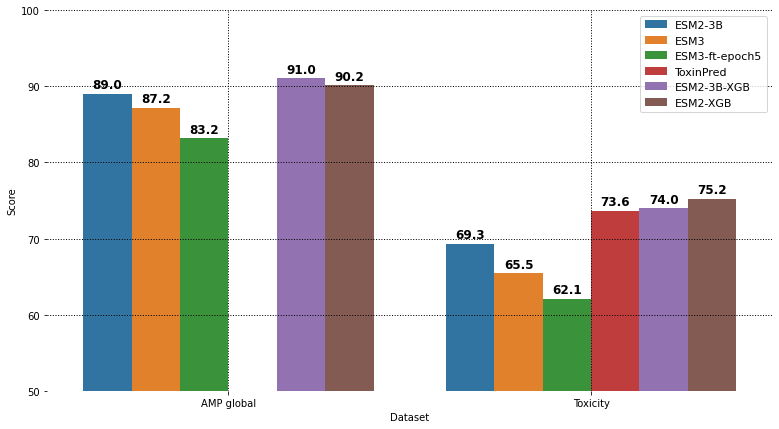

In [59]:
amp_subset_df = amp_df[amp_df['Dataset'].isin(['AMP global', 'Toxicity'])]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(13, 7))
barplot = sns.barplot(data=amp_subset_df[amp_subset_df['Metric'] == 'MCC'], x='Dataset', y='Score', hue='Base model')
plt.ylim([50, 100])
plt.grid(zorder=0, linewidth=1, linestyle=':', color='k')
plt.legend(prop={'size': 11})
plt.box(False)

# Annotate each bar with the value inside
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), textcoords = 'offset points',
                     fontsize=12, fontweight='bold')  # Set font size and bold
plt.savefig(f'testing_models_xgb.png', dpi=200, bbox_inches='tight')

In [123]:
for ds, ds_path in zip(['amp', 'G+', 'G-', 'tox'], 
                       ['../data/AMP_new/AMP_2024_08_09.tsv', '../data/AMP_new/AMP_2024_09_13_anti_Gram+.tsv',
                        '../data/AMP_new/AMP_2024_09_13_anti_Gram-.tsv', '../data/tox/tox_merged_all.tsv']):

    df = pd.read_csv(ds_path, sep='\t', header=None)
    cnt = Counter(df[3])
    print(f'{ds}, size={len(df)}, 0: {cnt[0]}', f'1: {cnt[1]}')


amp, size=55209, 0: 30205 1: 25004
G+, size=45069, 0: 30205 1: 14864
G-, size=45493, 0: 30205 1: 15288
tox, size=12961, 0: 6643 1: 6318


# Lab validation AMP Tox G+ G-

Total number of ripp peptides: 16709
ESM2-3B tox: {1: 3050, 0: 13659}
PTRANS tox: {1: 2810, 0: 13899}
ESM2-3B G-: {0: 11216, 1: 5493}
ESM2-3B amp: {1: 9294, 0: 7415}
ESM3 G+: {1: 6498, 0: 10211}
ESM3 amp: {1: 9447, 0: 7262}
ESM3 tox: {1: 1695, 0: 15014}
PTRANS amp: {1: 9313, 0: 7396}
PTRANS G+: {0: 10544, 1: 6165}
PTRANS G-: {0: 11050, 1: 5659}
ESM2-3B G+: {0: 10222, 1: 6487}
ESM3 G-: {1: 5642, 0: 11067}
amp active and non-toxic predicted by models: 2745
amp active and non-toxic predicted by models within top 50.0%: 481


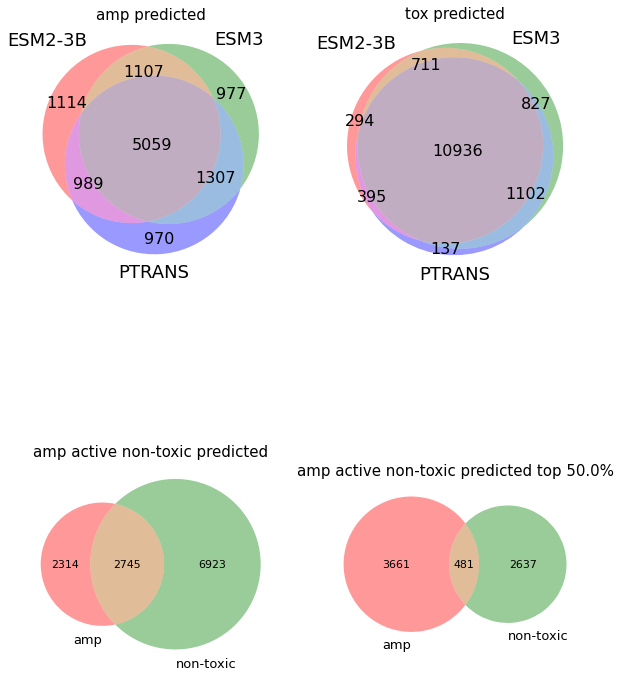

------------------------------------------------------------------------------------------
G+ active and non-toxic predicted by models: 1423
G+ active and non-toxic predicted by models within top 50.0%: 291


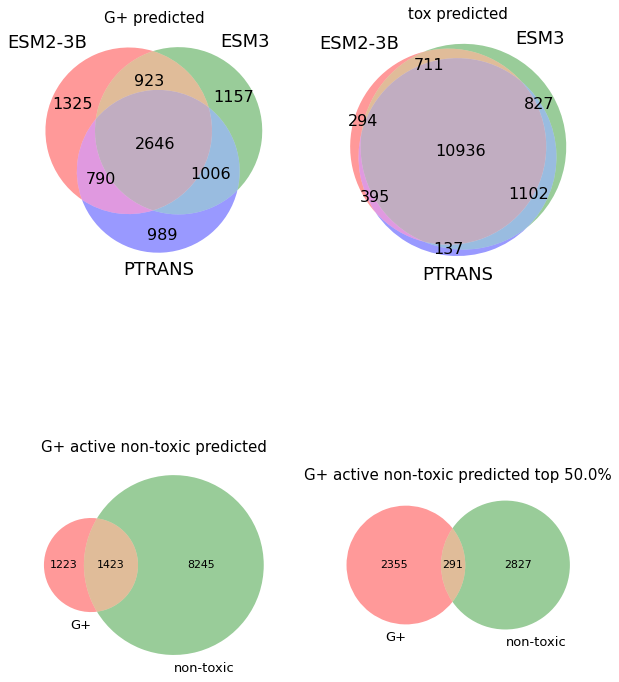

------------------------------------------------------------------------------------------
G- active and non-toxic predicted by models: 1117
G- active and non-toxic predicted by models within top 50.0%: 214


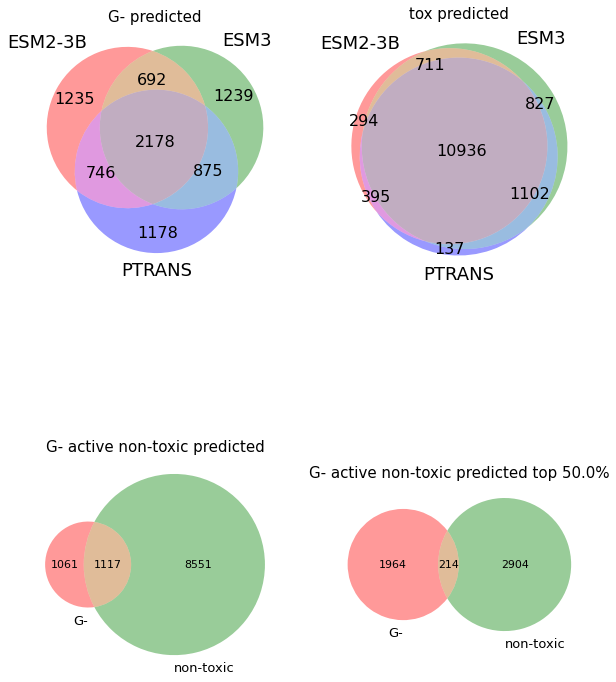

------------------------------------------------------------------------------------------


In [44]:
# Get data file names
path = '../data/predictions/lab_validation_2nd_round/ripp/'
out_path = path.replace('ripp/', '')
filenames = glob.glob(path + "*.tsv")
top_percs = {'amp': 0.5, 'G+': 0.5, 'G-':0.5, 'tox': 0.50}
intersect_4 = False  # If true uses all 4 models, if false use ESM3, ESM2-3B and PTRANS

dfs_raw = {'amp': dict(), 'G+':dict(), 'G-':dict(), 'tox': dict()}
dfs = {'amp': dict(), 'G+':dict(), 'G-':dict(), 'tox': dict()}
sets = {'amp': dict(), 'G+':dict(), 'G-':dict(), 'tox': dict()}
dfs_top_perc = {'amp': dict(), 'G+':dict(), 'G-':dict(), 'tox': dict()}
sets_top_perc = {'amp': dict(), 'G+':dict(), 'G-':dict(), 'tox': dict()}
orig_df = pd.read_csv('../data/ripp_core/ripp_12720_metagenomics_3989_microbial.tsv', sep='\t', header=None)#.tail(3989)
orig_df.loc[:, 'Type'] = ['Metagenomics' if x < 12720 else 'Microbial' for x in orig_df.index]
print(f'Total number of ripp peptides: {len(orig_df)}')

# Read ToxinPred3 prediction scores
toxin_df = pd.read_csv('../data/predictions/lab_validation_2nd_round/ripp/ripp_12720_metagenomics_3989_microbial_toxinpred.csv')#.tail(3989)
orig_df.loc[:, 'ToxinPred3'] = toxin_df['Prediction'].apply(lambda x: True if x == 'Toxin' else False)
non_toxin_pred = set(orig_df[~orig_df['ToxinPred3']][0])


for filename in filenames:
    model = os.path.basename(filename).split('_')[0]
    ds = os.path.basename(filename).split('_')[1]
    df = pd.read_csv(filename, sep='\t')#.tail(3989)
    size_top_perc = int(len(df) * top_percs[ds])
    dfs_raw[ds][model] = df.copy()
    if ds == 'tox':
        df = df[df['prediction'] == 0]  # Keep only non-toxic
    else:
        df = df[df['prediction'] == 1]  # Keep only AMP active
    df = df.sort_values(by='probability', ascending=False)
    # Normalize prediction score:
    df['probability_norm'] = (df['probability'] - df['probability'].min()) / (df['probability'].max() - df['probability'].min())
    df['probability_norm'] = df['probability_norm'].apply(lambda x: np.round(x, 4))
    if np.max(df['probability_norm'] ) > 1:
        display(df)
        break
    
    dfs[ds][model] = df.copy()
    sets[ds][model] = set(df['protein_id'].values)
    
    
    df = df.iloc[:size_top_perc, :]
    
    dfs_top_perc[ds][model] = df
    sets_top_perc[ds][model] = set(df['protein_id'].values)
    
    cnt = Counter(dfs_raw[ds][model]['prediction'])
    print(f'{model} {ds}: {dict(cnt)}')
    
for amp_ds in ['amp', 'G+', 'G-']:
    if intersect_4:
        amp_active = set.intersection(*list(sets[amp_ds].values()))
        non_toxic = set.intersection(*list(sets['tox'].values())).intersection(non_toxin_pred)
        amp_active_top = set.intersection(*list(sets_top_perc[amp_ds].values()))
        non_toxic_top = set.intersection(*list(sets_top_perc['tox'].values())).intersection(non_toxin_pred)
    else:
        amp_active = set.intersection(*[sets[amp_ds]['ESM2-3B'], sets[amp_ds]['ESM3'], sets[amp_ds]['PTRANS']])
        non_toxic = set.intersection(*[sets['tox']['ESM2-3B'], sets['tox']['ESM3'], sets['tox']['PTRANS']]).intersection(non_toxin_pred)
        amp_active_top = set.intersection(*[sets_top_perc[amp_ds]['ESM2-3B'], sets_top_perc[amp_ds]['ESM3'], sets_top_perc[amp_ds]['PTRANS']])
        non_toxic_top = set.intersection(*[sets_top_perc['tox']['ESM2-3B'], sets_top_perc['tox']['ESM3'], sets_top_perc['tox']['PTRANS']]).intersection(non_toxin_pred)

    
    for_lab = amp_active.intersection(non_toxic)
    for_lab_top_perc = amp_active_top.intersection(non_toxic_top)
    
    print(f'{amp_ds} active and non-toxic predicted by models: {len(for_lab)}')
    print(f'{amp_ds} active and non-toxic predicted by models within top {top_percs[amp_ds] * 100}%: {len(for_lab_top_perc)}')
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 14))
    for ind_st, st in enumerate([sets]):     # sets_top_perc
        for ind, ds in enumerate([amp_ds, 'tox']):
#             venn = venn2([st[ds]['ESM2'], st[ds]['ESM3']], set_labels=tuple('ESM2', 'ESM3'), ax=axs[ind_st][ind])
            if intersect_4:
                venn = venny4py(sets=st[ds], asax=axs[ind_st][ind])
            else:
                venn = venn3([st[ds]['ESM2-3B'], st[ds]['ESM3'], st[ds]['PTRANS']], set_labels=('ESM2-3B', 'ESM3', 'PTRANS'), ax=axs[ind_st][ind])
                for text in venn.set_labels:
                    text.set_fontsize(18)
                for text in venn.subset_labels:
                    if text:
                        text.set_fontsize(16)
            axs[ind_st][ind].set_title(f"{ds} predicted" + ((f' top {top_percs[ds]*100}%') if ind_st > 0 else ''), size=15)

    for ind, (act, tox) in enumerate(zip([amp_active, amp_active_top], [non_toxic, non_toxic_top])): 
        venn = venn2([act, tox], set_labels=tuple([amp_ds, 'non-toxic']), ax=axs[1][ind])
        for text in venn.set_labels:
            text.set_fontsize(13)
        for text in venn.subset_labels:
            if text:
                text.set_fontsize(11)
        axs[1][ind].set_title(f"{amp_ds} active non-toxic predicted" + ((f' top {top_percs[amp_ds]*100}%') if ind > 0 else ''), size=15)

    plt.savefig(f'{out_path}{amp_ds}_tox_ripp_venn.png', dpi=200, bbox_inches='tight')
    plt.show()
  
    for_lab_all_df = orig_df[ orig_df[0].isin(for_lab)]
    for_lab_all_df = for_lab_all_df.loc[:, for_lab_all_df.columns != 3]
    for_lab_all_df.columns = ['protein id', 'length', 'sequence', 'Type', 'ToxinPred3']  # ToxinPred 3 column
    for_lab_all_df.drop_duplicates(subset='sequence', inplace=True)
    score_columns = []
    for lab_ds in [amp_ds, 'tox']:
        for model in ['ESM2-3B', 'ESM3', 'PTRANS']:
            results_df = dfs[lab_ds][model][['protein_id', 'probability_norm']].drop_duplicates(subset='protein_id')
            for_lab_all_df = pd.merge(left=for_lab_all_df, right=results_df, 
                                      left_on='protein id', right_on='protein_id', how='left')

            for_lab_all_df.drop(columns='protein_id', inplace=True)
            for_lab_all_df.rename(columns={'probability_norm': lab_ds + '_' + model + '_norm_score'}, inplace=True)
            score_columns.append(lab_ds + '_' + model + '_norm_score')
    for_lab_all_df.loc[:, 'avg_score'] = for_lab_all_df[score_columns].mean(axis=1).apply(lambda x: np.round(x, 4))

    for_lab_all_df.loc[:, f'is_in_top_{int(top_percs[amp_ds]*100)}'] = for_lab_all_df['protein id'].isin(for_lab_top_perc)
    for_lab_all_df.sort_values(by='avg_score', inplace=True, ascending=False)
    for_lab_all_df.to_csv(f'{out_path}lab_validation_{amp_ds}.csv', index=False)
    print('-' * 90)
